In [1]:
import os
os.chdir('../')

In [2]:
import torch
import numpy as np
from src.dataset.utils import fgaid_to_fganame
from src.utils.reproducibility import make_reproducible

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

In [3]:
# Fix random state to make results reproducible
make_reproducible(random_seed=0)

id_to_action_name_dict = fgaid_to_fganame(
    fga_map_file="/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt"
)

Making reproducible on seed 0


In [4]:
from collections import Counter
import pandas as pd

labels = torch.load(
    # f="tsne_artefacts/train/TSN_InceptionV3_SS1_bs32_ns16_ep15_labels.pt", 
    f="tsne_artefacts/train/GSF_InceptionV3_SS1_bs32_ns16_ep15_labels.pt", 
    map_location=torch.device('cpu')
)
features = torch.load(
    # f="tsne_artefacts/train/TSN_InceptionV3_SS1_bs32_ns16_ep15_features.pt",
    f="tsne_artefacts/train/GSF_InceptionV3_SS1_bs32_ns16_ep15_features.pt",  
    map_location=torch.device('cpu')
)

labels = labels.numpy()
features = features.numpy()

Counter(labels).most_common(10)

[(1223, 4708),
 (1226, 4052),
 (1224, 3758),
 (1239, 3409),
 (1213, 2396),
 (1215, 2250),
 (1230, 2136),
 (22, 1867),
 (258, 1864),
 (1240, 1751)]

In [5]:
features.shape

(124759, 2048)

In [6]:
id_to_action_name_dict[22]

'grab-leg'

In [7]:
top10_labels = [label for label, cnt in Counter(labels).most_common(10)]
print(np.array(top10_labels))

[1223 1226 1224 1239 1213 1215 1230   22  258 1240]


In [8]:
# List to store all indices for top labels
all_indices = []

# Find indices for each top label and extend the list
for label in top10_labels:
    indices = np.where(labels == label)[0]
    all_indices.extend(indices)

all_indices = np.array(all_indices)

In [9]:
selected_labels = labels[all_indices]
selected_features = features[all_indices]

In [10]:
selected_labels = selected_labels[::10]
selected_features = selected_features[::10]

len(selected_labels), len(selected_features)

(2820, 2820)

In [11]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(selected_features)

In [13]:
selected_features.shape

(2820, 2048)

In [14]:
tsne = TSNE(
    n_components=2, 
    perplexity=30,
    learning_rate='auto',
    init='pca',
    verbose=0,
    n_iter=1500,
    random_state=0,
    n_jobs=-1
)
tsne_results = tsne.fit_transform(X)

/Users/artemmerinov/PycharmProjects/holoassist-challenge/.venv/lib/python3.10/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


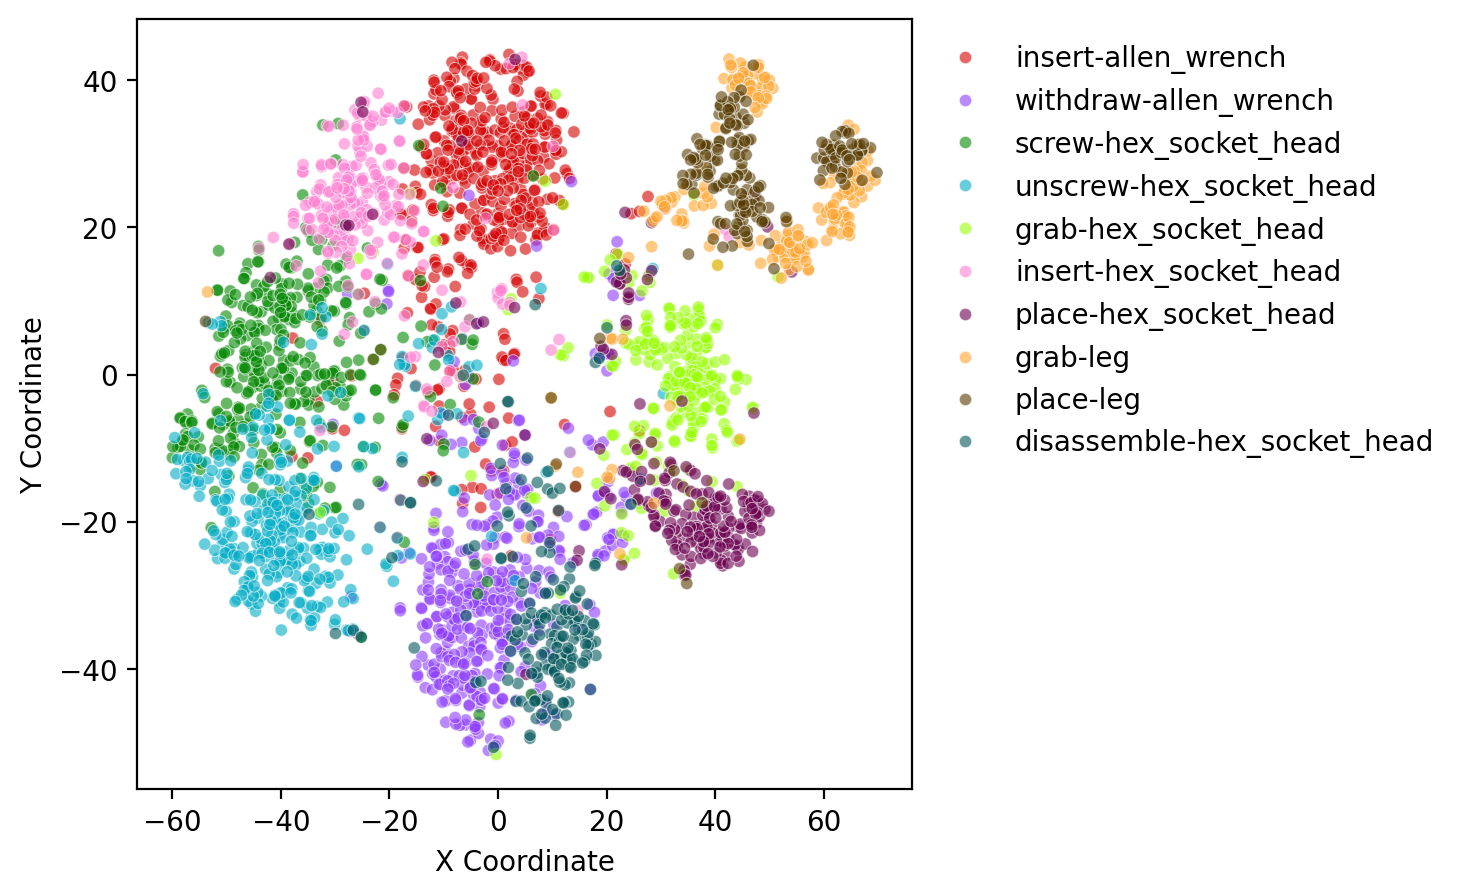

In [15]:
tsne_df = pd.DataFrame()
tsne_df["tsne_2d_one"] = tsne_results[:, 0]
tsne_df["tsne_2d_two"] = tsne_results[:, 1]
tsne_df["cluster"] = [id_to_action_name_dict[i] for i in selected_labels]

import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(selected_labels)))

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="tsne_2d_one",
    y="tsne_2d_two",
    hue="cluster",
    data=tsne_df,
    palette=palette,
    legend="full",
    alpha=0.6,
    s=20,
);

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(bbox_to_anchor=(1,1), frameon=False);